In [1]:
# System
import pandas as pd
import numpy as np
import pickle as pk
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import zlib
import time
import math
import random
import statistics
from collections import Counter


# Externals
import torch
import MinkowskiEngine as ME
from torch.utils.data import Dataset, DataLoader
from glob import glob
from glob import iglob
import os.path as osp, h5py, tqdm
import utils
from Core import utils
from Core.trainers import Trainer

import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import tqdm, psutil
from scipy.special import softmax
from sklearn.metrics import classification_report, confusion_matrix, explained_variance_score

/usr/local/lib64/python3.6/site-packages/MinkowskiEngine-0.5.2-py3.6-linux-x86_64.egg/MinkowskiEngine/__init__.py:42: UserWarning: The environment variable `OMP_NUM_THREADS` not set. MinkowskiEngine will automatically set `OMP_NUM_THREADS=16`. If you want to set `OMP_NUM_THREADS` manually, please export it on the command line before running a python script. e.g. `export OMP_NUM_THREADS=12; python your_program.py`. It is recommended to set it below 24.
  "It is recommended to set it below 24.",
/usr/local/lib64/python3.6/site-packages/MinkowskiEngine-0.5.2-py3.6-linux-x86_64.egg/MinkowskiEngine/__init__.py:224: UserWarning: The MinkowskiEngine was compiled with CPU_ONLY flag. If you want to compile with CUDA support, make sure `torch.cuda.is_available()` is True when you install MinkowskiEngine.
  "If you want to compile with CUDA support, make sure `torch.cuda.is_available()` is True when you install MinkowskiEngine.",


In [2]:
## Plotting parameters

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


## Choosing colorblind scheme
import matplotlib.style as style 
#style.use('seaborn-colorblind') 
style.use('tableau-colorblind10') 

# Plotting configuration


plt.rcParams['figure.figsize'] = [20, 12]

SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 24
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# from PDG to label
def pdg2tos(pdg):
    if pdg==13 or pdg==-13 or pdg==211 or pdg==-211:
        return 0 # track
    if pdg==2212 or pdg==321 or pdg==-321:
        return 0 # heavy track
    if pdg==11 or pdg==-11 or pdg==22:
        return 1 # shower
    return -1

def particle2pdg(name):
    if name == 'muon':
        return 13
    elif name == 'positive_muon':
        return -13
    elif name == 'pion':
        return 211
    elif name == 'negative_pion':
        return -211    
    elif name == 'proton':
        return 2212    
    elif name == 'positive_kaon':
        return 321    
    elif name == 'negative_kaon':
        return -321
    elif name == 'electron':
        return 11
    elif name == 'positron':
        return -11
        

### PDG values:

```
13 = muon (negative)
-13 = muon positive
211 = pion positive
-211 = pion negative
2212 = proton
321 = kaon postive
-321 = kaon negative
11 = electron 
-11 = positron
22 = gamma
```

In [4]:
# Define cut region 

select_region = False


## define cuts for beam
lower_x = -200 
upper_x = 200

lower_y = 200
upper_y = 600

lower_z = 0
upper_z = 300



def cut_coordinates_BEAM_region(x,y,z):    
    if lower_x < x < upper_x:
        if lower_y < y < upper_y:
            if lower_z < z < upper_z:
                return True
            else:
                return False
        else:
            return False
    else:
        return False    

# MC

In [5]:
# Generate events for MC

graph=0
voxel_size=0.05 # cm #original 

count_number_of_spacepoints = 0
number_of_spacepoints_skipped = 0
number_of_spacepoints_beam_region = 0

# DATA processed 
# - Selection of beam slice
# - Selection of primary particles only
# - Select only Tracks and Showers (using IsTrack and IsShower methods)
# - cut track objects from shower and viceversa (compare beampdg with what we have)
## ORIGINAL
#numGraphs = len(list(iglob('/afs/cern.ch/user/a/aabedabu/private/cernibox/physics_gnn/physics_processed_data_collection/prod4/grid_8000_with_track_id_particle_id_mother_particle_energy_processed_by_me_isParticle/1GeV_1/mc_sce_dd/*/*.gz')))
#for graph_path in iglob('/afs/cern.ch/user/a/aabedabu/private/cernibox/physics_gnn/physics_processed_data_collection/prod4/grid_8000_with_track_id_particle_id_mother_particle_energy_processed_by_me_isParticle/1GeV_1/mc_sce_dd/*/*.gz'):
## 300 event files
#PATH = '/eos/home-a/aabedabu/physics_gnn/physics_processed_data_collection/prod4/MC_prod4A/gcn_results_*_files/*/*.gz'
PATH = '/afs/cern.ch/user/a/aabedabu/private/cernibox/physics_gnn/physics_processed_data_collection/prod4/MC_prod4A_INFERENCE/*/*/*.gz'


numGraphs = len(list(iglob(PATH)))
for graph_path in iglob(PATH):
   
    if graph % 100 == 0:
      print(str(graph+1) + " out of " + str(numGraphs))
    example = {}
    with open(graph_path[:-3]+'.info', 'rb') as info_file:                        
        
        lines = info_file.readlines()
        values = {'X':float(lines[0]),
                  'Y':float(lines[1]),
                  'Z':float(lines[2]),
                  'Energy':float(lines[3]),
                  'Interaction':int(lines[4]),
                  'PDG':int(lines[5]),
                  'NumberOfNodes':int(lines[6]),
                  'NumberOfFeatures':int(lines[7])
                  }
        #print(values)
        
    nnodes = values['NumberOfNodes']
    nfeatures = values['NumberOfFeatures']
    
    # spatial coordinates
    XYZ=np.zeros(shape=(nnodes,3),dtype=float)
        
    # all nodes are usable by deafault
    usable = [True]*nnodes
        
    features = []
    X = []
    Y = []
    Z = []
    labels = []
    pdg_values = []
    track_id = []
    mother_particle_id = []
    event_number_id = []
    # iterate over nodes and save spatial coordinates
    event_number = graph_path.split(os.sep)[-2].split('_')[10]
    #event_number = 666
    
    with open(graph_path, 'rb') as graph_file:
        codes = np.fromstring(zlib.decompress(graph_file.read()), dtype=np.float32, sep='')
        for node_id in range(nnodes):
            # label
            
            pdg_true = codes[node_id*(3+nfeatures+4)+(3+nfeatures)]
            label = pdg2tos(pdg_true)

            track_true_id = codes[node_id*(3+nfeatures+4)+(3+nfeatures)+1]
            particle_true_id = codes[node_id*(3+nfeatures+4)+(3+nfeatures)+2]
            #print(track_true_id)
            #print(particle_true_id)
            #print(codes[node_id*(3+nfeatures+2)+(3+nfeatures)])
            if label == -1:
                continue

            # features
            feature = []
            for j in range(3,3+values['NumberOfFeatures']):
                feature.append(codes[node_id*(3+nfeatures+4)+j])

            x = codes[node_id*(3+nfeatures+4)+0]
            y = codes[node_id*(3+nfeatures+4)+1]
            z = codes[node_id*(3+nfeatures+4)+2]

            # Avoid hits that are not in the beam region    
            if select_region:
                if not cut_coordinates_BEAM_region(x,y,z):
                    number_of_spacepoints_beam_region += 1
                    continue
                           
            
            x = int(x/voxel_size)
            y = int(y/voxel_size)
            z = int(z/voxel_size)
            xyz = np.dstack((X,Y,Z)).reshape(len(X),3)

            ## ATTENTION: this will reduce the total number of hits
            count_number_of_spacepoints += 1
            if [x,y,z] in xyz:
                number_of_spacepoints_skipped += 1 
                continue

                 
                
            # coordinates
            X.append(x)
            Y.append(y)
            Z.append(z)
            labels.append(label)
            pdg_values.append(pdg_true)
            track_id.append(track_true_id)
            mother_particle_id.append(particle_true_id)
            event_number_id.append(int(event_number))
            
            ## Removing charge over distance feature
            #del feature[-3:] #delete last three
            
            # Remove only neighboring nodes
            #del feature[0:3]            
            
            features.append(feature)
    
    X = np.array(X)
    Y = np.array(Y)
    Z = np.array(Z)
    coords=np.dstack((X,Y,Z)).reshape(X.shape[0],3)
    features = np.array(features)
    labels = np.array(labels).reshape(X.shape[0],1)
    pdg_values = np.array(pdg_values).reshape(X.shape[0],1)
    track_id = np.array(track_id).reshape(X.shape[0],1)
    mother_particle_id = np.array(mother_particle_id).reshape(X.shape[0],1)
    event_number_id = np.array(event_number_id).reshape(X.shape[0],1)

    
    example['x'] = features
    example['c'] = coords
    example['y'] = labels
    example['track_ids'] = track_id
    example['mother_particle_ids'] = mother_particle_id
    example['pdg_values'] = pdg_values
    example['event_number_id'] = event_number_id

    torch.save(example, 'sparse_data_protodune_MC/event{}.pt'.format(graph))
    
    graph+=1


1 out of 2765


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:66: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


101 out of 2765
201 out of 2765
301 out of 2765
401 out of 2765
501 out of 2765
601 out of 2765
701 out of 2765
801 out of 2765
901 out of 2765
1001 out of 2765
1101 out of 2765
1201 out of 2765
1301 out of 2765
1401 out of 2765
1501 out of 2765
1601 out of 2765
1701 out of 2765
1801 out of 2765
1901 out of 2765
2001 out of 2765
2101 out of 2765
2201 out of 2765
2301 out of 2765
2401 out of 2765
2501 out of 2765
2601 out of 2765
2701 out of 2765


In [6]:
# Dataset class

class SparseEventProtoDUNE(Dataset):
    def __init__(self, root, shuffle=True, **kwargs):
        '''Initialiser for SparseEventProtoDUNE class'''
        
        self.root = root
        self.data_files = self.processed_file_names
        if shuffle:
            random.shuffle(self.data_files) 
        self.total_events = len(self.data_files)
        
    @property
    def raw_dir(self):
        return f'{self.root}/raw'
    
    @property
    def processed_dir(self):
        return f'{self.root}'

    @property
    def raw_file_names(self):
        ret = []
        for subdir in glob(f'{self.raw_dir}/*'):
            ret += glob(f'{subdir}/*.root')
        return ret
    
    @property
    def processed_file_names(self):
        return glob(f'{self.processed_dir}/*.pt')
    
    def __len__(self):
        return len(self.data_files)
    
    def __len__(self):
        return self.total_events
    
    def __getitem__(self, idx):
        data = torch.load(self.data_files[idx])
        c = torch.FloatTensor(data['c']) # 3 coordinates
        x = torch.FloatTensor(data['x']) #features
        y = torch.LongTensor(data['y']) # label (converted from PDG value)
        track_ids = torch.LongTensor(data['track_ids']) # track id 
        mother_particle_ids = torch.LongTensor(data['mother_particle_ids']) # mother id
        PDG_values = torch.LongTensor(data['pdg_values']) # PDG values
        event_number_id = torch.LongTensor(data['event_number_id']) # PDG values

        del data
        return { 'x': x, 'c': c, 'y': y, 'track_ids' : track_ids, 'mother_particle_ids' : mother_particle_ids, 'pdg_values' : PDG_values, "event_number_id" : event_number_id}
    
    def vet_files(self):
        for f in self.data_files:
            _, ext = osp.splitext(f)
            if ext != '.pt':
                print('Extension not recognised! Skipping')
                continue
            try:
                torch.load(f)
            except:
                print(f'File {f} is bad! Removing...')
                os.remove(f)

In [7]:
# Generate dataset (specificy location of the dataset)
dataset_MC =SparseEventProtoDUNE("sparse_data_protodune_MC")


In [8]:
# Checking feature data
event_from_dataset = dataset_MC.__getitem__(0)['x'].tolist()
print(event_from_dataset[0])

# Checking x coordinate
coordinate_from_dataset = dataset_MC.__getitem__(0)['c'].tolist()
print(coordinate_from_dataset[0])

# Checking pdg data
event_from_dataset = dataset_MC.__getitem__(0)['pdg_values'].tolist()
print("PDG value: ", event_from_dataset[0])

# Checking event id data
event_from_dataset = dataset_MC.__getitem__(0)['event_number_id'].tolist()
print("Event number: ", event_from_dataset[0])

# Some checks
number_images = len(dataset_MC)
#first_image = dataset_MC[0]
print('Number of images (or gcn.gz files to process or events):', number_images)

[16.0, 49.0, 159.0, 12.731365203857422, 0.05268534645438194, 0.020378202199935913, 564.0, 2160.0, 6463.0]
[-592.0, 8353.0, 591.0]
PDG value:  [211]
Event number:  [0]
Number of images (or gcn.gz files to process or events): 2765


In [9]:
# Collate function used in the ML part


def collate_sparse_minkowski_saul(batch):
    #coords, feats = ME.utils.sparse_collate([d['c'] for d in batch], [d['x'] for d in batch])
    #coords = ME.utils.batched_coordinates([d['c'] for d in batch], dtype=torch.float32)#([d['c'].int() for d in batch])
    voxel_size=1.0
    coords = [(d['c']/voxel_size).int() for d in batch]
    feats = torch.cat([d['x'] for d in batch])
    y = torch.cat([d['y'] for d in batch])
    ret = { 'f': feats, 'c': coords, 'y': y }
    return ret

In [10]:
# Prepare train, validation, testing, inference dataset

fulllen_MC = len(dataset_MC)
t_v_split_MC= 0.2
tv_num_MC = math.ceil(fulllen_MC*t_v_split_MC)
splits_MC=np.cumsum([fulllen_MC-2*tv_num_MC,0,tv_num_MC, 0, tv_num_MC])
print(splits_MC)


collate = collate_sparse_minkowski_saul

# Inference dataset takes all without splitting
inference_dataset_MC = torch.utils.data.Subset(dataset_MC,np.arange(start=0,stop=splits_MC[4]))
inference_loader_MC = DataLoader(inference_dataset_MC, collate_fn=collate, batch_size=32, num_workers=0, shuffle=False)

#inference_dataset_DATA = torch.utils.data.Subset(dataset_DATA,np.arange(start=0,stop=splits_DATA[4]))
#inference_loader_DATA = DataLoader(inference_dataset_DATA, collate_fn=collate, batch_size=32, num_workers=0, shuffle=False)



[1659 1659 2212 2212 2765]


In [11]:
## ====================================================================
## This module defines a generic trainer for simple models and datasets 
## ====================================================================

# Locals
from Core.models import get_model
from Core.trainers.base import base
from Core.loss import get_loss
from Core.activation import get_activation
from Core.optim import get_optim
from Core.scheduler import get_scheduler
from Core.metrics import get_metrics
from Core.utils import *

class Trainer(base):
    """Trainer code for basic classification problems with categorical cross entropy."""

    def __init__(self, train_name="test1", summary_dir="summary",
        empty_cache = None, **kwargs):
        super(Trainer, self).__init__(train_name=train_name, **kwargs)
        self.writer = SummaryWriter(f"{summary_dir}/{train_name}")
        self.empty_cache = empty_cache
        
    def arrange_sparse_minkowski(self, data):
        return ME.SparseTensor(
                           features=data['f'], 
                           coordinates=ME.utils.batched_coordinates(data['c'], dtype=torch.float32)#,
                           #quantization_mode=ME.SparseTensorQuantizationMode.RANDOM_SUBSAMPLE, 
                           #device=self.device
                           )
    
    def arrange_truth(self, data):
        return data['y']

    def build_model(self, optimizer_params=None, scheduler_params=None,
        loss_params=None, metric_params=None, name="NodeConv",
        arrange_data="arrange_sparse_minkowski", arrange_truth="arrange_sparse",
        **model_args):
        """Instantiate our model"""

        self.train_name = name
            
        # Construct the model
        #torch.cuda.set_device(self.device)
        self.model = get_model(name=name, **model_args)
        #self.model = self.model.to(self.device)        
        
        # Construct the loss function
        #self.loss_func = get_loss(**loss_params)
        self.loss_func = nn.CrossEntropyLoss()#get_loss(func="categorical_cross_entropy")

        # Construct the optimizer
        #self.optimizer = get_optim(model_params=self.model.parameters(), **optimizer_params)
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
        #self.scheduler = get_scheduler(self.optimizer, **scheduler_params)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=3)
        '''
        scheduler_params = {"ReduceLROnPlateau":{"factor":0.9,"patience":0.3},
                            "StepLR":{"step_size":5, "gamma":0.8}}
        self.scheduler = get_scheduler(self.optimizer, "ReduceLROnPlateau")
        '''
        self.scheduler = None
        
        'Classification'
        # Configure metrics
        '''
        metrics=metric_params["metrics"]
        metric_args = metric_params[metrics]
        self.metrics = get_metrics(metrics)(**metric_args)
        '''
        #self.metrics = get_metrics("Classification")(["track", "heavy_track", "shower"])
        self.metrics = get_metrics("Classification")(["track", "shower"])
        #self.metrics = get_metrics("Classification")(["protons", "muons"])
        #self.batch_metrics = metric_params["include_batch_metrics"]
        self.batch_metrics = "yes"
        
        '''
        # Select function to arrange data
        self.arrange_data = get_arrange_data(arrange_data)
        self.arrange_truth = get_arrange_truth(arrange_truth)
        '''

    def load_state_dict(self, state_dict, **kwargs):
        """Load state dict from trained model"""
        self.model.load_state_dict(torch.load(state_dict)["model"])

    def train_epoch(self, data_loader, **kwargs):
        """Train for one epoch"""
        self.model.train()
        self.metrics.new_epoch()
        summary = dict()
        sum_loss = 0.
        start_time = time.time()
        # Loop over training batches
        batch_size = data_loader.batch_size
        n_batches = int(math.ceil(len(data_loader.dataset)/batch_size)) #if max_iters_train is None else max_iters_train
        t = tqdm.tqdm(enumerate(data_loader),total=n_batches)
        for i, data in t:
            self.optimizer.zero_grad()
            # Different input shapes for SparseConvNet vs MinkowskiEngine
            batch_input = self.arrange_sparse_minkowski(data)
            batch_output = self.model(batch_input)
            batch_target = self.arrange_truth(data)#.to(self.device)
            batch_target = torch.reshape(batch_target, (len(batch_target),))
            
            batch_loss = nn.functional.cross_entropy(batch_output.F, batch_target, reduction="mean")
            batch_loss.backward()
            
            softmax(batch_output.F.detach().numpy(), axis=-1)

            # Calculate accuracy
            metrics = self.metrics.train_batch_metrics(batch_output.F, batch_target)
            
            self.optimizer.step()

            sum_loss += batch_loss.item()
            t.set_description("loss = %.5f" % batch_loss.item() )
            t.refresh() # to show immediately the update

            # add to tensorboard summary
            if self.batch_metrics:
                metrics = self.metrics.train_batch_metrics(batch_output.F, batch_target)
                if self.iteration%100 == 0:
                    self.writer.add_scalar("loss/batch", batch_loss.item(), self.iteration)
                    for key, val in metrics.items(): self.writer.add_scalar(key, val, self.iteration)
            self.iteration += 1

            if self.empty_cache is not None and self.iteration % self.empty_cache == 0:
                #torch.cuda.empty_cache()
                print("")

        summary["lr"] = self.optimizer.param_groups[0]["lr"]
        summary["train_time"] = time.time() - start_time
        summary["train_loss"] = sum_loss / n_batches
        self.logger.debug(" Processed %i batches", n_batches)
        self.logger.info("  Training loss: %.3f", summary["train_loss"])
        self.logger.info("  Learning rate: %.5f", summary["lr"])
        return summary
    
    @torch.no_grad()
    def evaluate(self, data_loader, max_iters_eval=None, **kwargs):
        """Evaluate the model"""
        self.model.eval()
        summary = dict()
        sum_loss = 0
        start_time = time.time()
        # Loop over batches
        batch_size = data_loader.batch_size
        n_batches = int(math.ceil(len(data_loader.dataset)/batch_size))
        t = tqdm.tqdm(enumerate(data_loader),total=n_batches)
        true=[]
        pred=[]
        raw_pred = []
        for i, data in t:
            batch_input = self.arrange_sparse_minkowski(data)
            batch_output = self.model(batch_input)
            batch_target = self.arrange_truth(data).to(batch_output.device)
            batch_target = torch.reshape(batch_target, (len(batch_target),))
            
            
            pred+=np.argmax(softmax(batch_output.F.cpu().detach().numpy(),axis=-1), axis=-1).tolist()
            raw_pred.append(softmax(batch_output.F.cpu().detach().numpy(),axis=-1).tolist())
            true+=batch_target.cpu().detach().numpy().tolist()
            
            batch_loss = self.loss_func(batch_output.F, batch_target)
            sum_loss += batch_loss.item()
            self.metrics.valid_batch_metrics(batch_output.F, batch_target)
        summary["valid_time"] = time.time() - start_time
        summary["valid_loss"] = sum_loss / n_batches
        self.logger.debug(" Processed %i samples in %i batches",
                          len(data_loader.sampler), n_batches)
        self.logger.info("  Validation loss: %.3f" % (summary["valid_loss"]))
        return summary, np.array(true), np.array(pred), np.array(raw_pred)
    
    def train(self, train_data_loader, n_epochs, resume=False, valid_data_loader=None, sherpa_study=None, sherpa_trial=None, **kwargs):
        """Run the model training"""

        # Loop over epochs
        best_valid_loss = 99999
        self.first_epoch = 0
        if resume:
            self.logger.info("Resuming existing training!")
            state_dict = None
            while True:
                state_files = glob(f"{self.output_dir}/checkpoints/*{self.first_epoch:03d}.pth.tar")
                if len(state_files) > 1:
                    raise Exception(f"More than one state file found for epoch {self.first_epoch}!")
                elif len(state_files) == 0:
                    self.logger.info(f"Resuming training from epoch {self.first_epoch}.")
                    self.load_state_dict(state_dict)
                    break
                state_dict = state_files[0]
                self.first_epoch += 1
        n_batches = int(math.ceil(len(train_data_loader.dataset)/train_data_loader.batch_size))
        self.iteration = self.first_epoch * n_batches
        for i in range(self.first_epoch, n_epochs):
            self.logger.info("Epoch %i" % i)
            self.writer.add_scalar("learning_rate", self.optimizer.param_groups[0]["lr"], i+1)
            summary = dict(epoch=i)
            # Train on this epoch
            sum_train = self.train_epoch(train_data_loader, **kwargs)
            summary.update(sum_train)
            # Evaluate on this epoch
            sum_valid = None
            if valid_data_loader is not None:
                sum_valid, true_pid, pred_pid = self.evaluate(valid_data_loader, **kwargs)
                summary.update(sum_valid)

                if sum_valid["valid_loss"] < best_valid_loss:
                    best_valid_loss = sum_valid["valid_loss"]
                    self.logger.debug("Checkpointing new best model with loss: %.3f", best_valid_loss)
                    self.write_checkpoint(checkpoint_id=i,best=True)

            if self.scheduler is not None:
                self.scheduler.step(sum_valid["valid_loss"])

            # Save summary, checkpoint
            self.save_summary(summary)
            if self.output_dir is not None:
                self.write_checkpoint(checkpoint_id=i)

            self.writer.add_scalars('loss/epoch', {
                'train': summary['train_loss'],
                'valid': summary['valid_loss'] }, i+1)
            metrics = self.metrics.epoch_metrics()
            if sherpa_study is not None and sherpa_trial is not None:
                sherpa_study.add_observation(
                trial=sherpa_trial,
                iteration=i,
                objective=metrics["acc/epoch"]["valid"])
            for key, val in metrics.items(): self.writer.add_scalars(key, val, i+1)
            for key, val in metrics.items(): print(key, val)
            if valid_data_loader is not None:
                print(confusion_matrix(pred_pid, true_pid))
            

        return self.summaries
    
def _test():
    t = Trainer(output_dir="./")
    t.build_model()


In [12]:
## Build the model 

trainer = Trainer(device=0, n_epochs=10, max_iters_train=None, max_iters_eval=None,
                  summary_dir='summary/3d/test', output_dir='./')

name = "MinkUNet14A"

trainer.build_model(name=name,
                    in_channels=9, out_channels=2, D=3
                   )
# Path where the model is located

#PATH = './test1/checkpoints/ALL_FEATURES/model_checkpoint_MinkUNet14A_8046754_ccc7aa238f_aabdabu_009.pth.tar'
PATH_prod4 = './test1/checkpoints/ALL_FEATURES/model_checkpoint_MinkUNet14A_8046754_ccc7aa238f_aabdabu_009.pth.tar'
PATH_prod4A = './test1/checkpoints/ALL_FEATURES/model_checkpoint_MinkUNet14A_8046754_ccc7aa238f_aabedabu_009_PROD4A.pth.tar'
# Load the model 
trainer.load_state_dict(PATH_prod4A)


In [13]:
# Apply the model to the MC dataset

summary_MC, true_pid_MC, pred_pid_MC, raw_network_output_MC = trainer.evaluate(data_loader=inference_loader_MC)

  0%|          | 0/87 [00:00<?, ?it/s]/usr/local/lib64/python3.6/site-packages/MinkowskiEngine-0.5.2-py3.6-linux-x86_64.egg/MinkowskiEngine/MinkowskiSparseTensor.py:288: UserWarning: coordinates implicitly converted to torch.IntTensor. To remove this warning, use `.int()` to convert the coords into an torch.IntTensor
  + "coords into an torch.IntTensor"
100%|██████████| 87/87 [00:20<00:00,  4.29it/s]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:173: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [14]:
# Apply the model to the data dataset

# summary_DATA, true_pid_DATA, pred_pid_DATA, raw_network_output_DATA = trainer.evaluate(data_loader=inference_loader_DATA)

# Analysis of the results

In [15]:
## ===============================
## Get raw values from the network
## ===============================

def get_track_raw_pid(input_list):
    
    output_list = []
    for x_list in input_list:
        for ml_track in x_list:
            output_list.append(ml_track[0])
    return output_list

def get_shower_raw_pid(input_list):
    output_list = []
    for x_list in input_list:
        for ml_track in x_list:
            output_list.append(ml_track[1])
    return output_list

track_raw_pid_values_MC = get_track_raw_pid(raw_network_output_MC)
shower_raw_pid_values_MC = get_shower_raw_pid(raw_network_output_MC)

print("SANITY CHECKS:")
print("Number of predicted PIDs: ", len(pred_pid_MC))
print("Number of track network raw output: ", len(track_raw_pid_values_MC))
print("Number of shower network raw output: ", len(shower_raw_pid_values_MC))

# Example
#print(track_raw_pid_values[0:10])
#print(shower_raw_pid_values[0:10])


SANITY CHECKS:
Number of predicted PIDs:  514795
Number of track network raw output:  514795
Number of shower network raw output:  514795


In [16]:
print("Number of spacepoints processed: ", len(true_pid_MC))
print("Total number of events analyzed: ", len(dataset_MC))
print("Number of events in inference dataset: ", len(inference_dataset_MC))


Number of spacepoints processed:  514795
Total number of events analyzed:  2765
Number of events in inference dataset:  2765


In [17]:
number_true_track_hits = 0
number_true_shower_hits = 0
for element in true_pid_MC:
    if element == 0: 
        number_true_track_hits += 1 
    if element == 1:
        number_true_shower_hits += 1 

print("True track hits: ", number_true_track_hits)
print("True shower hits: ", number_true_shower_hits)

number_pred_track_hits = 0
number_pred_shower_hits = 0
for element in pred_pid_MC:
    if element == 0: 
        number_pred_track_hits += 1 
    if element == 1:
        number_pred_shower_hits += 1 

print("Pred track hits: ", number_pred_track_hits)
print("Pred shower hits: ", number_pred_shower_hits)



True track hits:  382737
True shower hits:  132058
Pred track hits:  386728
Pred shower hits:  128067


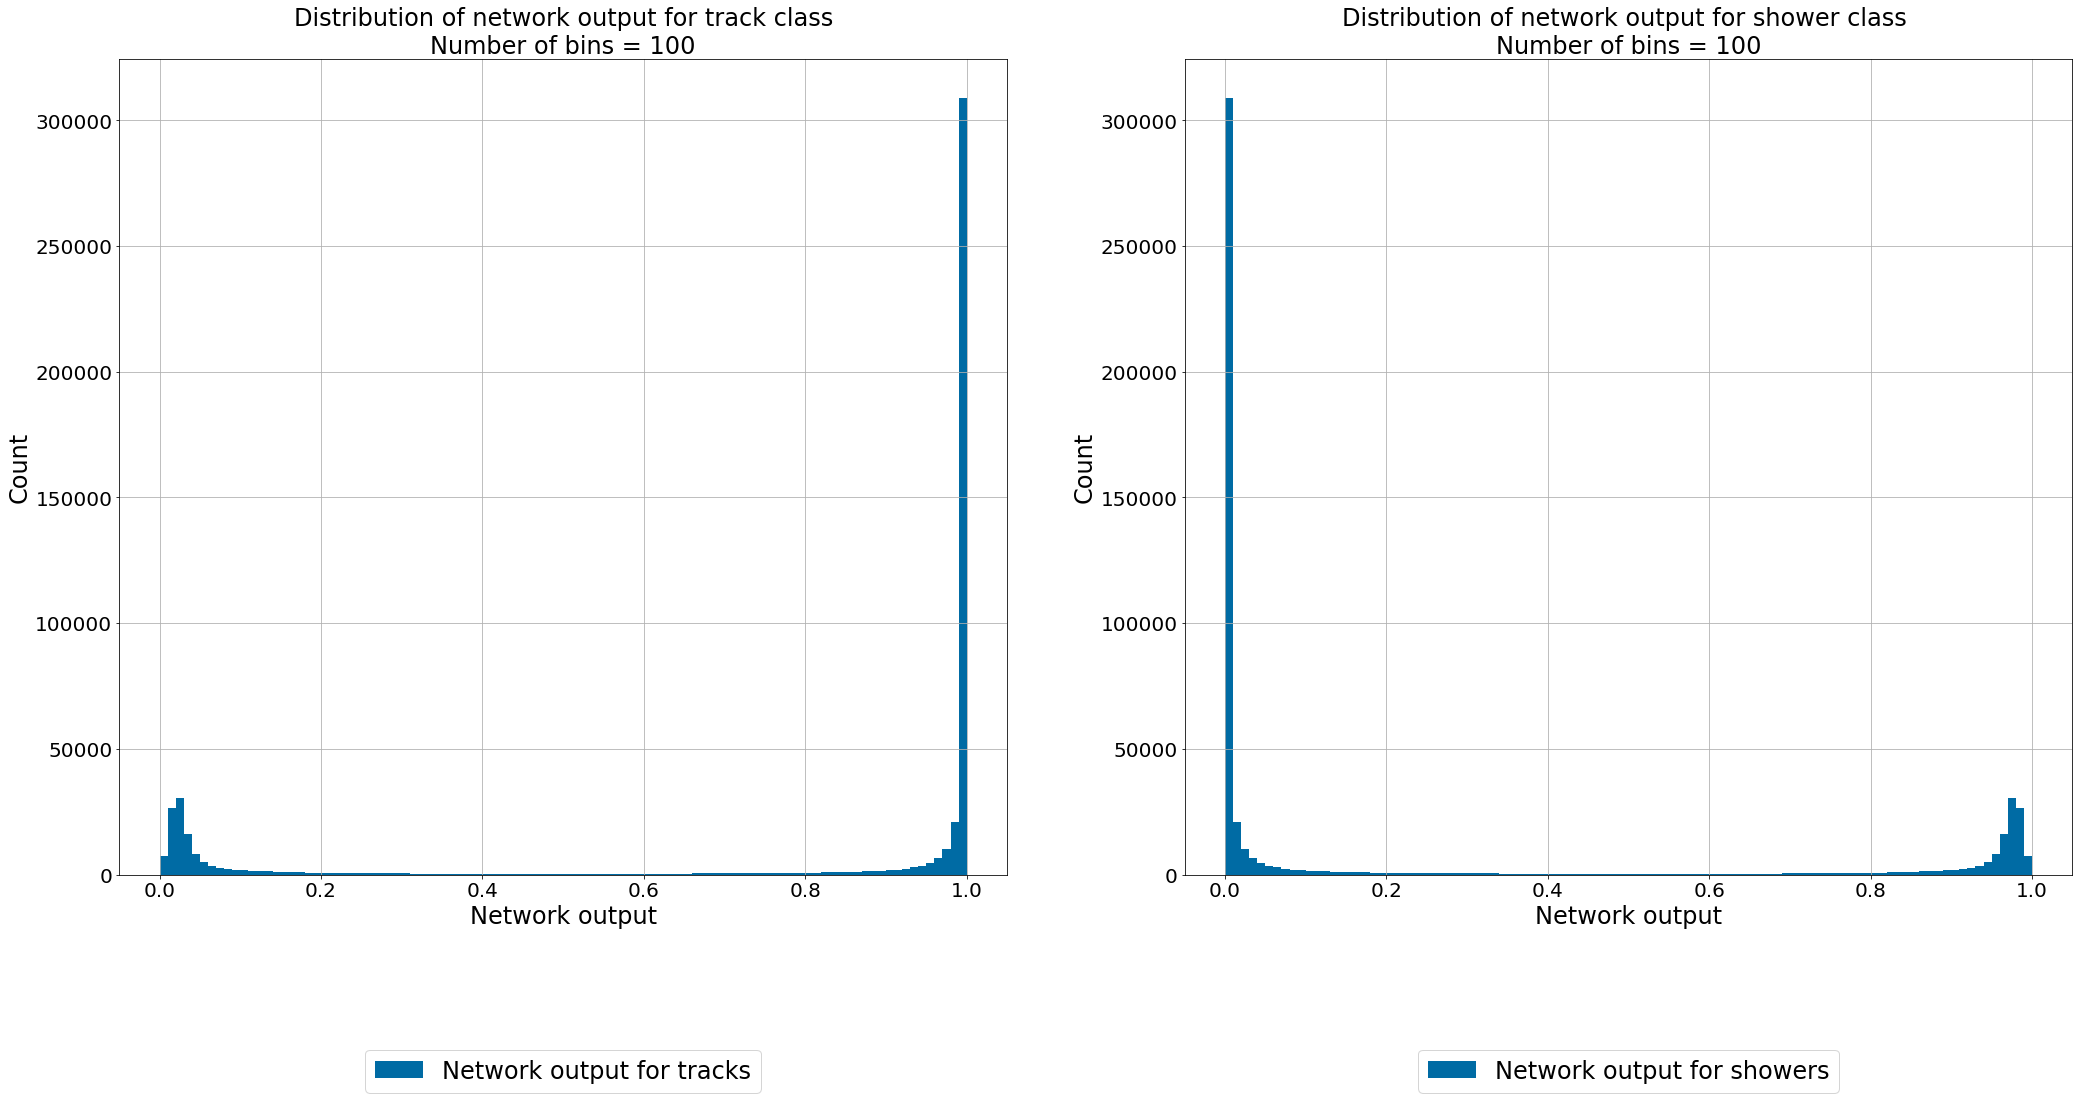

In [18]:
## =====================================================================
## Plotting histogram of raw network output for track and shower classes
## =====================================================================

fig = plt.figure(figsize=(35,15))
n_bins = 100

ax = fig.add_subplot(1,2,1)
plt.hist(track_raw_pid_values_MC, n_bins, label="Network output for tracks")


plt.title("Distribution of network output for track class\n"
           "Number of bins = " + str(n_bins))
plt.xlabel("Network output")
plt.ylabel('Count')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom
plt.savefig("plot/hist_raw_network_output_track.png")



ax = fig.add_subplot(1,2,2)
plt.hist(shower_raw_pid_values_MC, n_bins, label="Network output for showers")

plt.title("Distribution of network output for shower class \n"
           "Number of bins = " + str(n_bins))
plt.xlabel("Network output")
plt.ylabel('Count')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom



plt.savefig("plot/hist_raw_network_output_shower.png")


In [19]:
# Statistics

target_names = ["track", "shower"]
print(classification_report(true_pid_MC, pred_pid_MC, digits=4, target_names=target_names))
print(confusion_matrix(pred_pid_MC, true_pid_MC))

              precision    recall  f1-score   support

       track     0.9683    0.9784    0.9733    382737
      shower     0.9354    0.9071    0.9210    132058

    accuracy                         0.9601    514795
   macro avg     0.9518    0.9427    0.9471    514795
weighted avg     0.9598    0.9601    0.9599    514795

[[374458  12270]
 [  8279 119788]]


In [20]:
## ===================================================================
## Get the true values for the coordinates, labels, pdg values and ids
## ===================================================================

import itertools

voxel_size = 0.05
x_true = []
y_true = []
z_true = []
label_true = []
label_predicted = pred_pid_MC.tolist()

track_id_true = []
mother_particle_id_true = []
pdg_values_true = []
event_ids_true = []


# Testing dataset indices
index_start_testing = 0
index_stop_testing =splits_MC[4]
print("Start index: ", index_start_testing)
print("Stop index: ", index_stop_testing)
#print(len(dataset.__getitem__(750)['y']))

# Flatten the tensors
for idx in range(index_start_testing, index_stop_testing):
    list2d_label = dataset_MC.__getitem__(idx)['y'].tolist()
    merged_label = list(itertools.chain(*list2d_label))
    label_true.extend(merged_label)
    
    list2d_track_id = dataset_MC.__getitem__(idx)['track_ids'].tolist()
    merged_track_id = list(itertools.chain(*list2d_track_id))
    track_id_true.extend(merged_track_id)

    list2d_mother_particle_id = dataset_MC.__getitem__(idx)['mother_particle_ids'].tolist()
    merged_mother_particle_id = list(itertools.chain(*list2d_mother_particle_id))
    mother_particle_id_true.extend(merged_mother_particle_id)
    
    list2d_pdg_values = dataset_MC.__getitem__(idx)['pdg_values'].tolist()
    merged_pdg_values = list(itertools.chain(*list2d_pdg_values))
    pdg_values_true.extend(merged_pdg_values)
   
    list2d_event_ids_values = dataset_MC.__getitem__(idx)['event_number_id'].tolist()
    merged_event_ids_values = list(itertools.chain(*list2d_event_ids_values))
    event_ids_true.extend(merged_event_ids_values)
   
   

    
    list2d_coords = dataset_MC.__getitem__(idx)['c'].tolist()
    for event_list in list2d_coords:
        x_true.append(event_list[0]*voxel_size)
        y_true.append(event_list[1]*voxel_size)
        z_true.append(event_list[2]*voxel_size)
        
        


# Some checks
print("SANITY CHECKS")
print("Number of true Tracks and showers ", len(label_true))
print("Number of predicted PIDs ", len(pred_pid_MC))
print("Number of predicted x-coordinates ", len(x_true))
print("Number of true PDG values ", len(pdg_values_true))
print("Number of event ids (one for each hit)", len(event_ids_true))
print("Number of true track IDs (shower and tracks)", len(track_id_true))


Start index:  0
Stop index:  2765
SANITY CHECKS
Number of true Tracks and showers  514795
Number of predicted PIDs  514795
Number of predicted x-coordinates  514795
Number of true PDG values  514795
Number of event ids (one for each hit) 514795
Number of true track IDs (shower and tracks) 514795


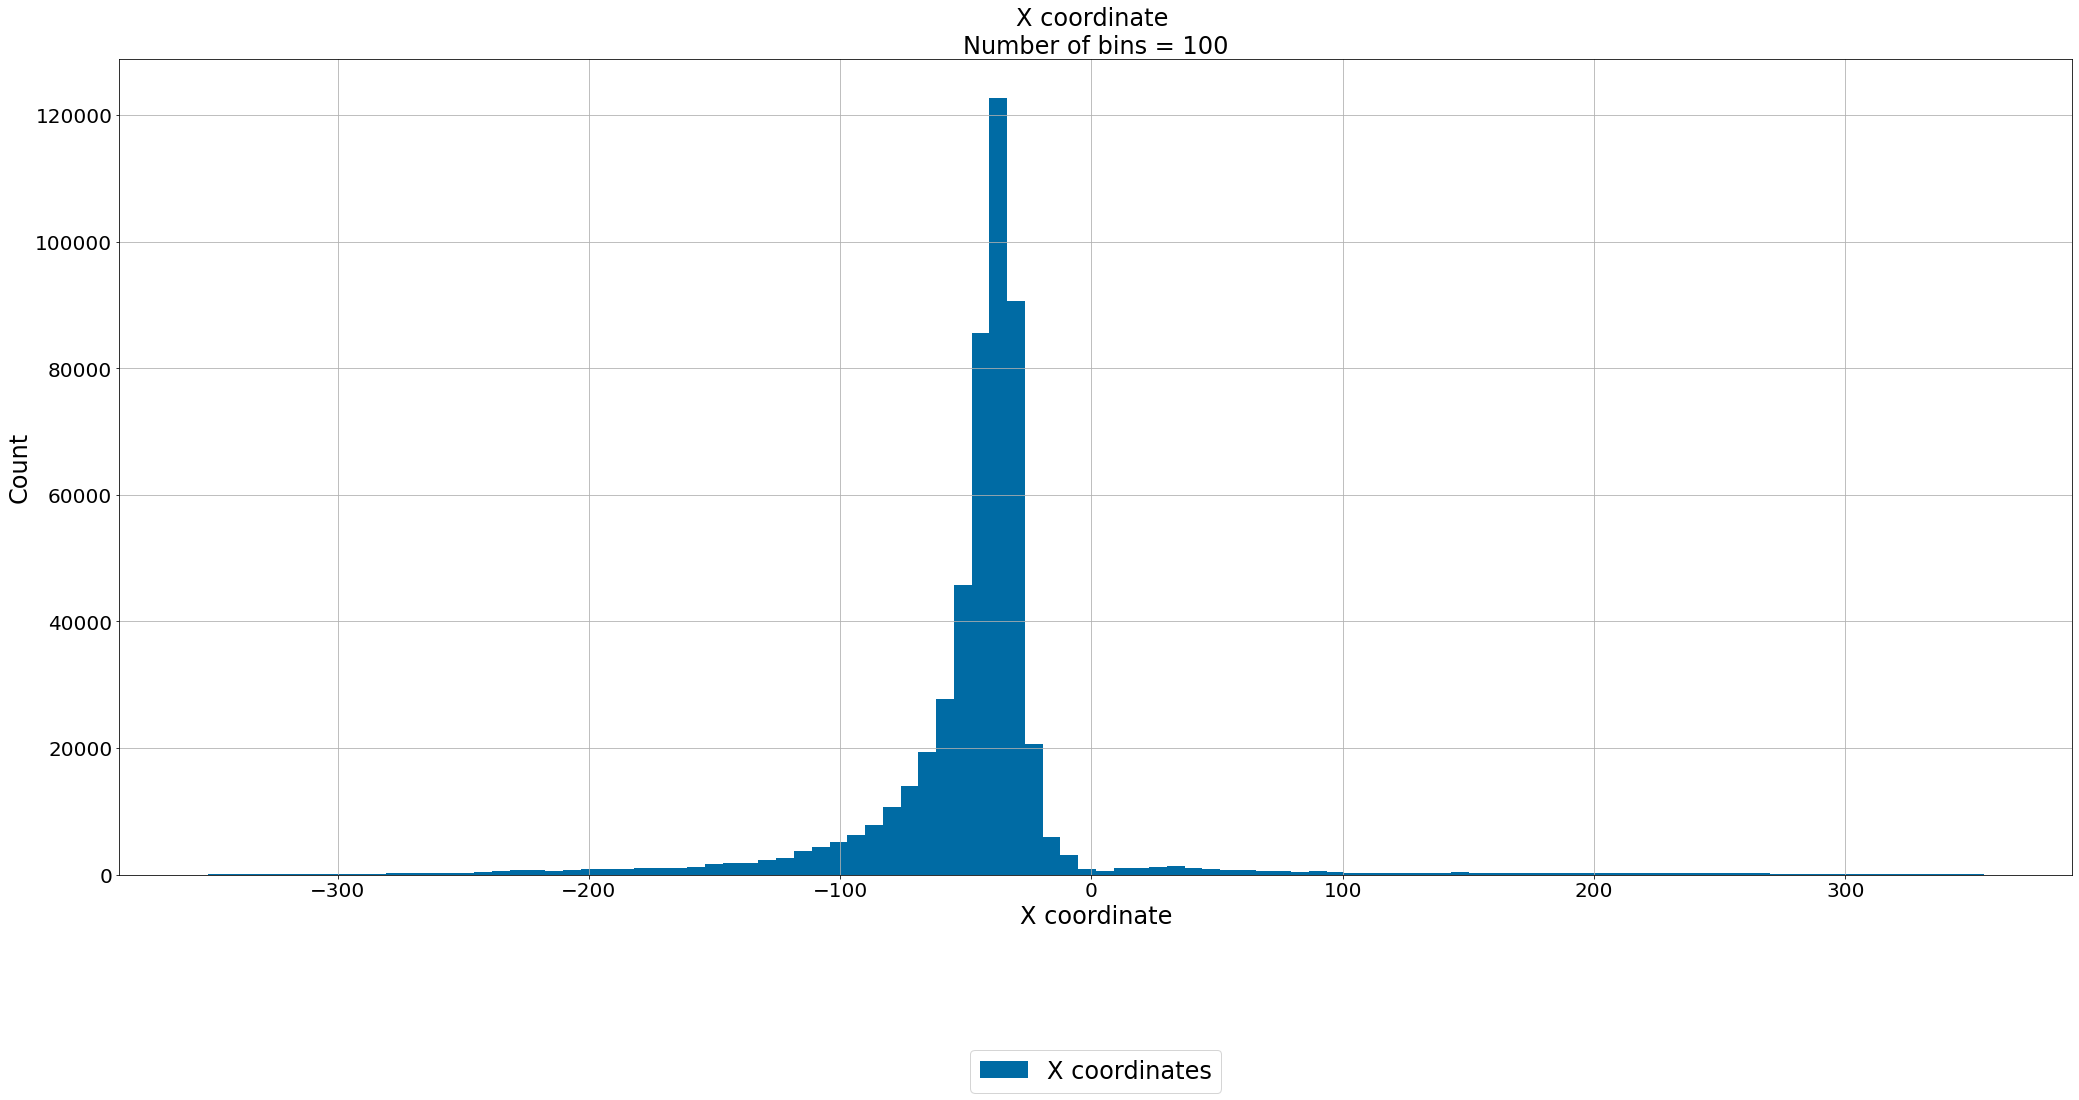

In [21]:
## ================================
## SANITY CHECK (x coord histogram)
## ================================


fig = plt.figure(figsize=(35,15))
ax = fig.add_subplot()

n_bins = 100
plt.hist(x_true, n_bins, label="X coordinates")


ax.set_xlabel('X coordinate')
ax.set_ylabel('Count')
plt.title("X coordinate \n"
           "Number of bins = " + str(n_bins))
plt.xlabel("X coordinate")
plt.ylabel('Count')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom



plt.savefig("plot/hist_x_coordinate_sanity_check.png")



In [22]:
## COMPUTE PURITY AND EFF for several cuts

def get_confusion_matrix_elements(true_list, ml_list, theshold_cut):
    true_tracks_predicted_as_tracks = 0   # true tracks
    true_tracks_predicted_as_showers = 0  # false showers
    true_showers_predicted_as_tracks = 0  # false tracks 
    true_showers_predicted_as_showers = 0 # true showers
    
    for i in range(len(true_list)):
        if true_list[i] == 0:
            if ml_list[i] > theshold_cut:
                true_tracks_predicted_as_tracks += 1
            else: 
                true_tracks_predicted_as_showers += 1
        else:
            if ml_list[i] > theshold_cut:
                true_showers_predicted_as_tracks += 1
            else: 
                true_showers_predicted_as_showers += 1
    return true_tracks_predicted_as_tracks,true_tracks_predicted_as_showers,true_showers_predicted_as_tracks,true_showers_predicted_as_showers


TP,FN,FP,TN = get_confusion_matrix_elements(true_pid_MC, track_raw_pid_values_MC, 0.1)


def get_track_shower_purity(TP,FN,FP,TN):
    track_purity = TP/(TP+FP)
    shower_purity = TN/(TN+FN)
    return track_purity, shower_purity

def get_track_shower_efficiency(TP,FN,FP,TN):
    track_eff = TP/(TP+FN)
    shower_eff = TN/(TN+FP)
    return track_eff, shower_eff
    

threshold_cuts = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]  

track_purity_list = []
shower_purity_list = []
track_efficiency_list = []
shower_efficiency_list = []

for cut in threshold_cuts:
    TP,FN,FP,TN = get_confusion_matrix_elements(true_pid_MC, track_raw_pid_values_MC, cut)
    pur_track, pur_shower = get_track_shower_purity(TP,FN,FP,TN)
    eff_track, eff_shower = get_track_shower_efficiency(TP,FN,FP,TN)
    track_purity_list.append(pur_track)
    shower_purity_list.append(pur_shower)
    track_efficiency_list.append(eff_track)
    shower_efficiency_list.append(eff_shower)

<Figure size 21000x5600 with 0 Axes>

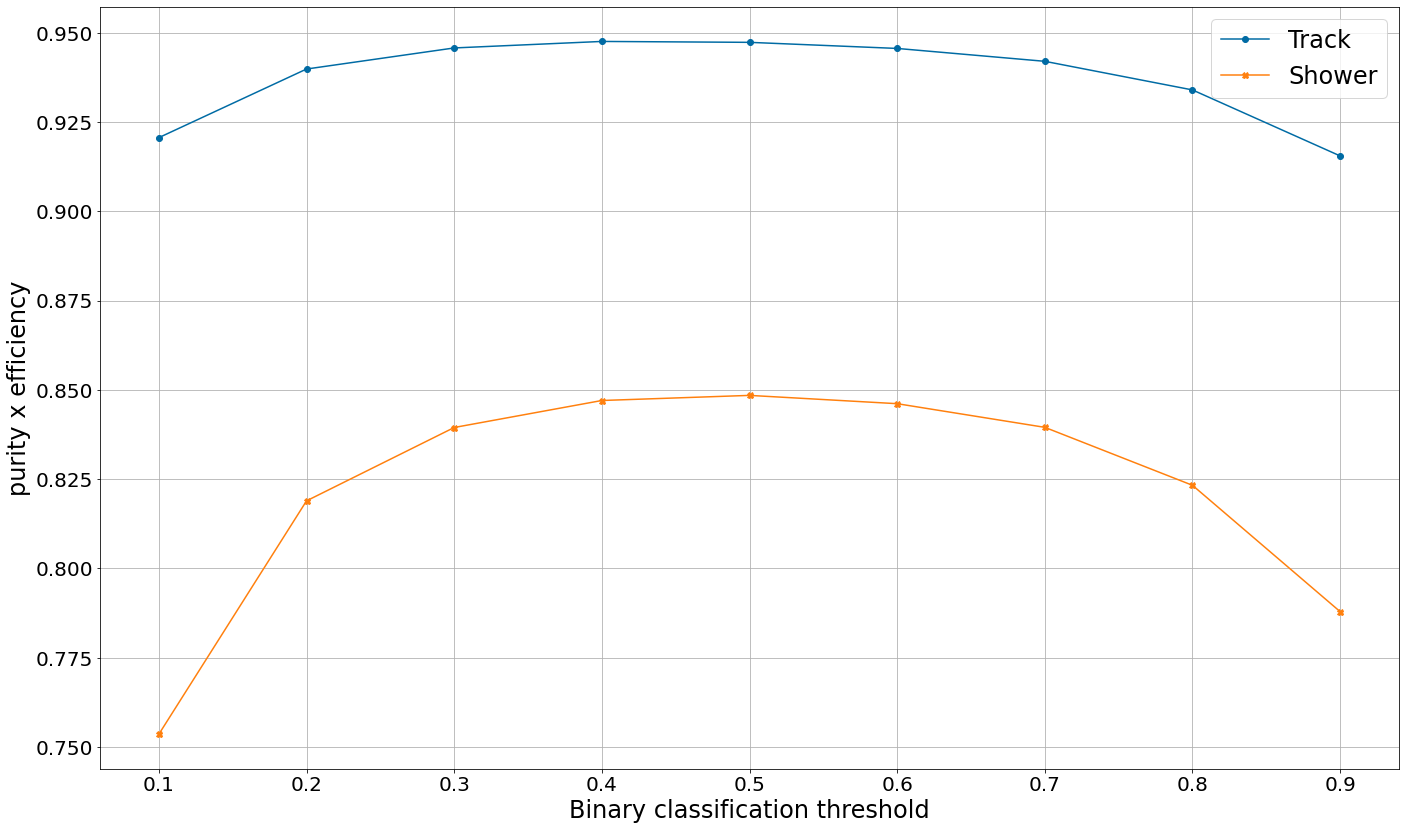

In [23]:
# Plot the track and shower efficiency*purity 

plt.figure(figsize=(30, 8), dpi=700)
fig = plt.figure()
ax1 = fig.add_subplot(111)
plots = []


classification_thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
purity_efficiency_track = []
purity_efficiency_shower = []

for idx in range(len(track_purity_list)):
    purity_efficiency_track.append(float(track_purity_list[idx]) * float(track_efficiency_list[idx]))
    purity_efficiency_shower.append(float(shower_purity_list[idx]) * float(shower_efficiency_list[idx]))


plots = ax1.plot(classification_thresholds, purity_efficiency_track,  marker='o', label="Track")
plots = ax1.plot(classification_thresholds, purity_efficiency_shower,  marker='X', label="Shower")

ax1.set_xlabel('Binary classification threshold')
ax1.set_ylabel('purity x efficiency')



plt.grid()

plt.legend(loc='best')


plt.tight_layout(pad=1)


plt.savefig('plot/purity_efficiency_treshold_cut', dpi=400)



## Plot of shower sparse net output for track hits and shower hits

In [24]:
def get_shower_sparse_net_output_for_track_and_shower_hits(true_list, ml_list):
    output_list_tracks = []
    output_list_showers = []
    for i in range(len(true_list)):
        if true_list[i] == 0: # it is a track
            output_list_tracks.append(ml_list[i])        
        else:
            output_list_showers.append(ml_list[i])        
    return output_list_tracks,output_list_showers

shower_sparse_net_output_for_track_hits = []
shower_sparse_net_output_for_shower_hits = []

shower_sparse_net_output_for_track_hits, shower_sparse_net_output_for_shower_hits = get_shower_sparse_net_output_for_track_and_shower_hits(true_pid_MC, shower_raw_pid_values_MC)



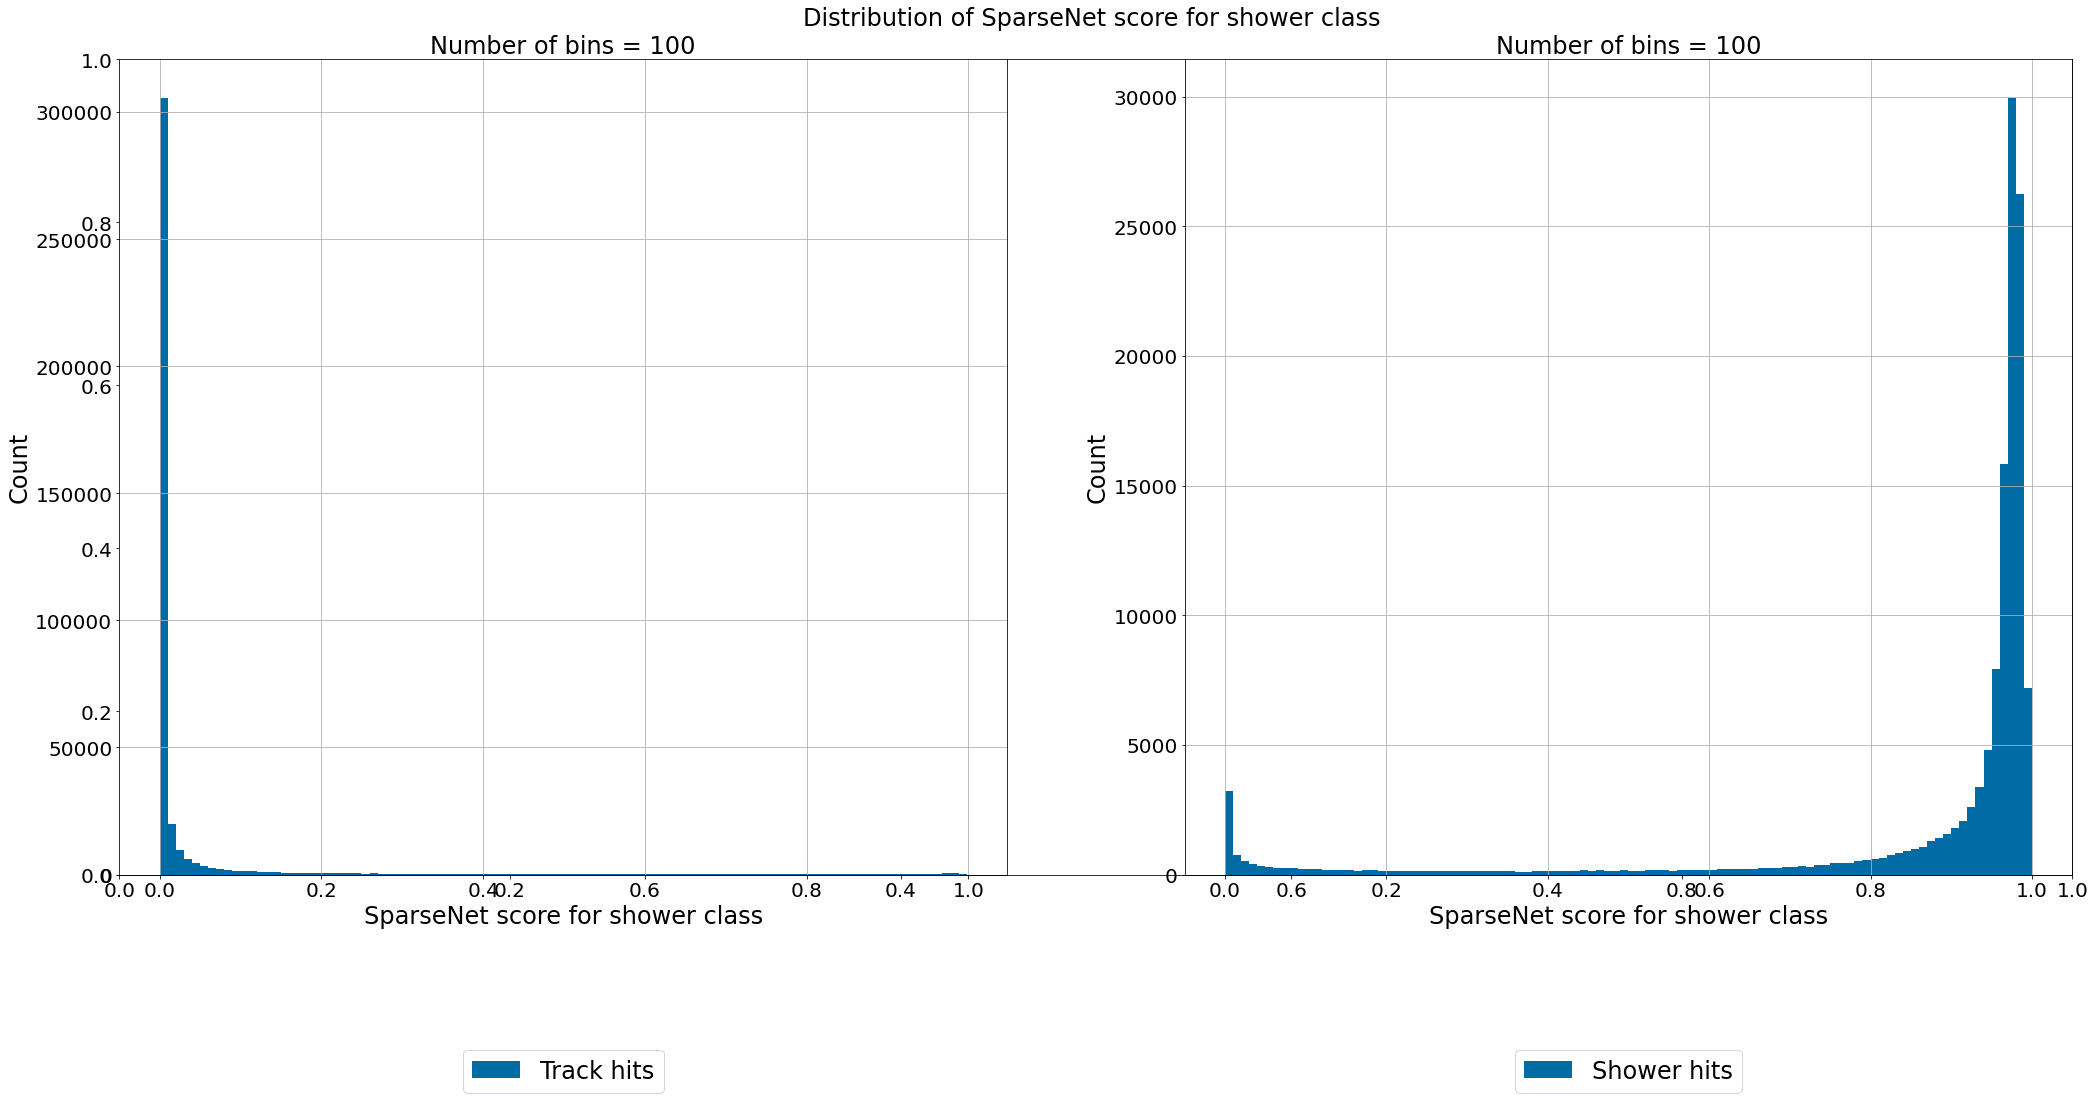

In [25]:
## =========================================================================
## Plotting histogram of shower SparseNet network output for track and shower hits
## =========================================================================

fig = plt.figure(figsize=(35,15))
n_bins = 100
plt.title("Distribution of SparseNet score for shower class \n")
ax = fig.add_subplot(1,2,1)
plt.hist(shower_sparse_net_output_for_track_hits, n_bins, label="Track hits")


plt.title("Number of bins = " + str(n_bins))
plt.xlabel("SparseNet score for shower class")
plt.ylabel('Count')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom
plt.savefig("plot/hist_raw_network_output_track.png")



ax = fig.add_subplot(1,2,2)
plt.hist(shower_sparse_net_output_for_shower_hits, n_bins, label="Shower hits")

plt.title("Number of bins = " + str(n_bins))
plt.xlabel("SparseNet score for shower class")
plt.ylabel('Count')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom



plt.savefig("plot/hist_shower_network_output_track_and_shower_hits.png")


132058.0


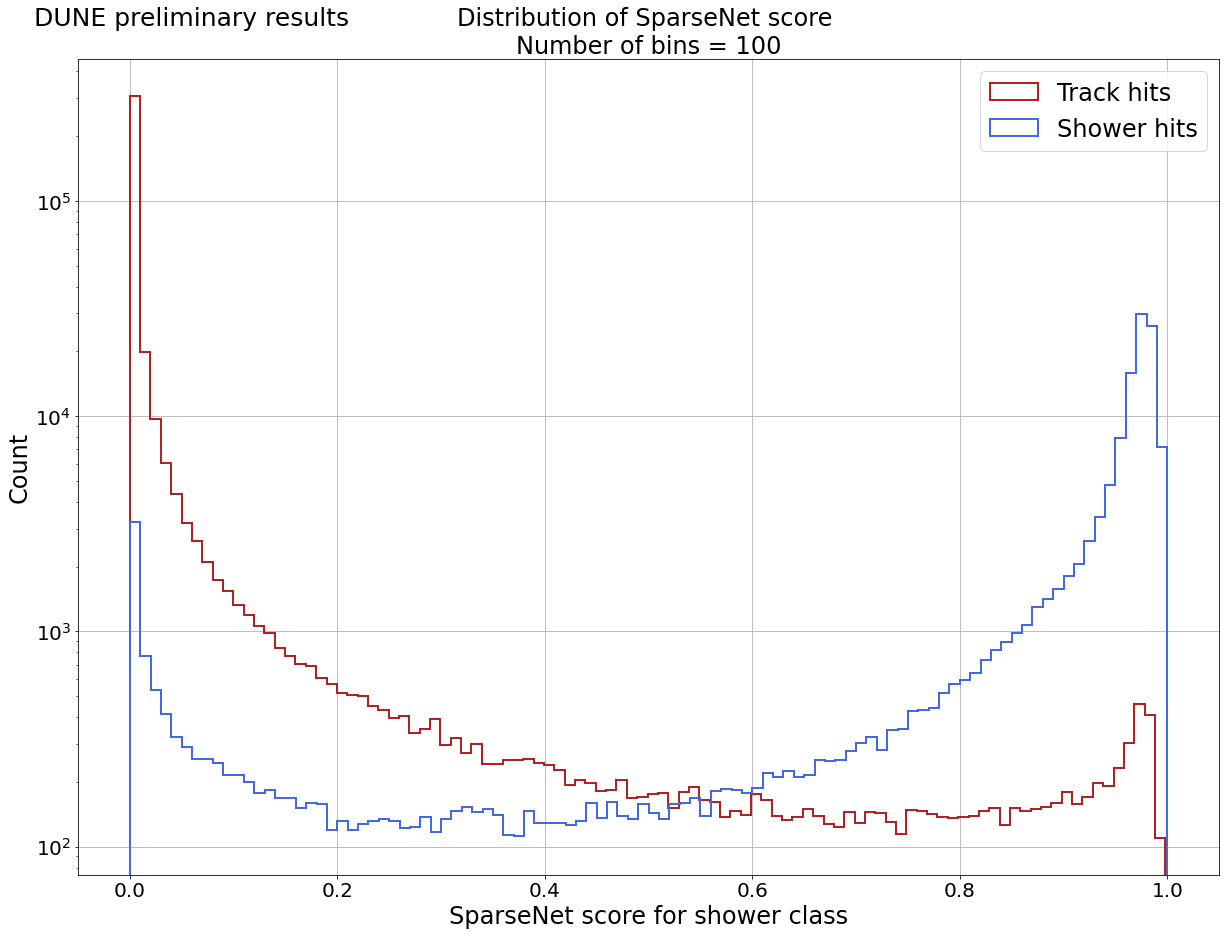

In [26]:
## =========================================================================
## Plotting histogram of shower SparseNet network output for track and shower hits
## =========================================================================

fig = plt.figure(figsize=(45,15))
n_bins = 100

ax = fig.add_subplot(1,2,1)
plt.hist(shower_sparse_net_output_for_track_hits, n_bins, histtype='step', label="Track hits", stacked=True, color='firebrick',  linewidth=2)
counts, edges, plot = plt.hist(shower_sparse_net_output_for_shower_hits, n_bins, histtype='step', label="Shower hits", stacked=True, color='royalblue',  linewidth=2)

nentries = 0 
for bin_entry in counts: 
    nentries += bin_entry
print(nentries)
    
plt.title("Distribution of SparseNet score \n"
           "Number of bins = " + str(n_bins))
plt.xlabel("SparseNet score for shower class")
plt.ylabel('Count')
plt.grid()
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom
plt.legend(loc='best')

plt.text(0.1, 1.05,'DUNE preliminary results',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes, fontsize=25)

plt.yscale('log') 


plt.savefig("plot/hist_shower_network_output_track_and_shower_hits.png")


#  Analysis per particle type

In [ ]:
# Get raw network output for specific particle type

def get_raw_output_prob_track(input_list, PDG):
    output_list = []
    index=0
    for x_list in input_list:
        for ml_track in x_list:
            if pdg_values_true[index] == PDG:
                output_list.append(ml_track[0])
            index+=1 
    return output_list    

prob_track_for_pion = get_raw_output_prob_track(raw_network_output_MC, 211)
prob_track_for_muon = get_raw_output_prob_track(raw_network_output_MC, 13)
prob_track_for_proton = get_raw_output_prob_track(raw_network_output_MC, 2212)
prob_track_for_positron = get_raw_output_prob_track(raw_network_output_MC, -11)
prob_track_for_electron = get_raw_output_prob_track(raw_network_output_MC, 11)

In [ ]:
print(len(prob_track_for_pion))
print(len(prob_track_for_muon))
print(len(prob_track_for_proton))
print(len(prob_track_for_positron))
print(len(prob_track_for_electron))



### FANCY WAY
### Get raw network output for specific particle type

```
prob_track_muon = []
prob_track_positive_muon = []
prob_track_positive_pion = []
prob_track_negative_pion = []
prob_track_for_tracks = {"muon": prob_track_muon, "positive_muon": prob_track_positive_muon, "positive_pion": prob_track_positive_pion, "negative_pion": prob_track_negative_pion}

prob_track_proton = []
prob_track_positive_kaon = []
prob_track_negative_kaon = []

prob_track_for_heavy_track = {"proton": prob_track_proton, "positive_kaon": prob_track_positive_kaon, "negative_kaon": prob_track_negative_kaon}

prob_track_electron = []
prob_track_positron = []
prob_track_for_showers = {"electron": prob_track_electron, "positron": prob_track_positron }



def get_raw_output_prob_track(input_list, prob_track_for_tracks):
    index=0    
    for x_list in input_list:
        for ml_track in x_list:
            if pdg_values_true[index] == 13: 
                prob_track_for_tracks["muon"].append(ml_track[0])
            elif pdg_values_true[index] == -13:
                prob_track_for_tracks["positive_muon"].append(ml_track[0]) 
            elif pdg_values_true[index] == 211:
                prob_track_for_tracks["positive_pion"].append(ml_track[0])    
            elif pdg_values_true[index] == -211:
                prob_track_for_tracks["negative_pion"].append(ml_track[0])      
            elif pdg_values_true[index] == 2212:
                prob_track_for_heavy_track["proton"].append(ml_track[0])         
            elif pdg_values_true[index] == 321:
                prob_track_for_heavy_track["positive_kaon"].append(ml_track[0])       
            elif pdg_values_true[index] == -321:
                prob_track_for_heavy_track["negative_kaon"].append(ml_track[0])
            elif pdg_values_true[index] == 11:
                prob_track_for_showers["electron"].append(ml_track[0])  
            elif pdg_values_true[index] == -11:
                prob_track_for_showers["positron"].append(ml_track[0])  
            index+=1 
    return prob_track_for_tracks    

prob_track = get_raw_output_prob_track(raw_network_output, prob_track_for_tracks)


# Tracks
print(len(prob_track_for_tracks['muon']))
print(len(prob_track_for_tracks['positive_muon']))
print(len(prob_track_for_tracks['positive_pion']))
print(len(prob_track_for_tracks['negative_pion']))

# Heavy tracks
print(len(prob_track_for_heavy_track['proton']))
print(len(prob_track_for_heavy_track['positive_kaon']))
print(len(prob_track_for_heavy_track['negative_kaon']))

# Shower
print(len(prob_track_for_showers['electron']))
print(len(prob_track_for_showers['positron']))
```

In [ ]:
# Get raw network output for specific particle type
def get_raw_output_prob_shower(input_list, PDG):
    output_list = []
    index=0
    for x_list in input_list:
        for ml_track in x_list:
            if pdg_values_true[index] == PDG:
                output_list.append(ml_track[1])
            index+=1
    return output_list    

prob_shower_for_pion = get_raw_output_prob_shower(raw_network_output_MC, 211)
prob_shower_for_muon = get_raw_output_prob_shower(raw_network_output_MC, 13)
prob_shower_for_proton = get_raw_output_prob_shower(raw_network_output_MC, 2212)
prob_shower_for_positron = get_raw_output_prob_shower(raw_network_output_MC, -11)
prob_shower_for_electron = get_raw_output_prob_shower(raw_network_output_MC, 11)

In [ ]:
print(len(prob_shower_for_pion))
print(len(prob_shower_for_muon))
print(len(prob_shower_for_proton))
print(len(prob_shower_for_positron))
print(len(prob_shower_for_electron))

In [ ]:
## ===============================================================
## Plotting histogram of probability of being a track or a shower
## ===============================================================


plt.rcParams['figure.figsize'] = [20, 12]

SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 35
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig = plt.figure(figsize=(35,15))
n_bins = 100



plt.hist(prob_shower_for_pion, n_bins, histtype='step', label="MC", stacked=True, color='firebrick',  linewidth=2)


plt.title("SparseNet output for shower class\n"
          "Particle type: pion \n"
           "Number of bins = " + str(n_bins) + "\n")
plt.xlabel("SparseNet score for shower class")
plt.ylabel('Hits count')
plt.yscale('log') 


plt.text(0, 0.95,'DUNE:ProtoDUNE-SP',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes, fontsize=30, weight='bold')


plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1)) #on the bottom
#plt.legend(loc='upper right')



plt.savefig("plot/hist_prob_shower_for_pion.png")


In [ ]:
## ===============================================================
## Plotting histogram of probability of being a track or a shower
## ===============================================================


plt.rcParams['figure.figsize'] = [20, 12]

SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 35
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig = plt.figure(figsize=(35,15))
n_bins = 100

plt.hist(prob_shower_for_muon, n_bins, histtype='step', label="MC", stacked=True, color='firebrick',  linewidth=2)

plt.title("SparseNet output for shower class\n"
          "Particle type: muon \n"
           "Number of bins = " + str(n_bins) + "\n")
plt.xlabel("SparseNet score for shower class")
plt.ylabel('Hits count')
plt.yscale('log') 

plt.text(0, 0.95,'DUNE:ProtoDUNE-SP',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes, fontsize=30, weight='bold')



plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1)) #on the bottom
#plt.legend(loc='upper right')



plt.savefig("plot/hist_prob_shower_for_muon.png")


In [ ]:
## ===============================================================
## Plotting histogram of probability of being a track or a shower
## ===============================================================


plt.rcParams['figure.figsize'] = [20, 12]

SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 35
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



fig = plt.figure(figsize=(35,15))
n_bins = 100

#plt.hist(prob_shower_for_proton, n_bins, label="Network output for showers")
plt.hist(prob_shower_for_proton, n_bins, histtype='step', label="MC", stacked=True, color='firebrick',  linewidth=2)



plt.title("SparseNet output for shower class\n"
          "Particle type: proton \n"
           "Number of bins = " + str(n_bins) + "\n")
plt.xlabel("SparseNet score for shower class")
plt.ylabel('Hits count')
plt.yscale('log') 

plt.text(0, 0.95,'DUNE:ProtoDUNE-SP',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes, fontsize=30, weight='bold')


plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1)) #on the bottom



plt.savefig("plot/hist_prob_shower_for_proton.png")


In [ ]:
## ===============================================================
## Plotting histogram of probability of being a track or a shower
## ===============================================================

plt.rcParams['figure.figsize'] = [20, 12]

SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 35
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



fig = plt.figure(figsize=(35,15))
n_bins = 100

#plt.hist(prob_shower_for_positron, n_bins, label="Network output for showers")
plt.hist(prob_shower_for_positron, n_bins, histtype='step', label="MC", stacked=True, color='firebrick',  linewidth=2)


plt.title("SparseNet output for shower class\n"
          "Particle type: positron \n"
           "Number of bins = " + str(n_bins) + "\n")
plt.xlabel("SparseNet score for shower class")
plt.ylabel('Hits count')
plt.yscale('log') 

plt.text(0, 0.95,'DUNE:ProtoDUNE-SP',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes, fontsize=30, weight='bold')


plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1)) #on the bottom



plt.savefig("plot/hist_prob_shower_for_positron.png")


In [ ]:
## ===============================================================
## Plotting histogram of probability of being a track or a shower
## ===============================================================

plt.rcParams['figure.figsize'] = [20, 12]

SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 35
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig = plt.figure(figsize=(35,15))
n_bins = 100

#plt.hist(prob_shower_for_electron, n_bins, label="Network output for showers")
plt.hist(prob_shower_for_electron, n_bins, histtype='step', label="MC", stacked=True, color='firebrick',  linewidth=2)


plt.title("SparseNet output for shower class\n"
          "Particle type: electron \n"
           "Number of bins = " + str(n_bins) + "\n")
plt.xlabel("SparseNet score for shower class")
plt.ylabel('Hits count')
plt.yscale('log') 

plt.text(0, 0.95,'DUNE:ProtoDUNE-SP',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes, fontsize=30, weight='bold')

plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1)) #on the bottom



plt.savefig("plot/hist_prob_shower_for_electron.png")


In [ ]:
## ===============================================================
## Plotting histogram of probability of being a shower for all particles
## ===============================================================

plt.rcParams['figure.figsize'] = [20, 12]

SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 35
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig = plt.figure(figsize=(35,15))
n_bins = 100


plt.hist(prob_shower_for_pion, n_bins, histtype='step', label="MC - pion", stacked=True, color='blue', linewidth=2)
plt.hist(prob_shower_for_muon, n_bins, histtype='step', label="MC - muon", stacked=True, color='red', linewidth=2)
plt.hist(prob_shower_for_proton, n_bins, histtype='step', label="MC - proton", stacked=True, color='green', linewidth=2)
plt.hist(prob_shower_for_positron, n_bins, histtype='step', label="MC - positron", stacked=True, color='purple', linewidth=2)
#plt.hist(prob_shower_for_electron, n_bins, histtype='step', label="MC - electron", stacked=True, linewidth=2)


plt.title("SparseNet output for shower class\n"
           "Number of bins = " + str(n_bins) )
plt.xlabel("SparseNet score for shower class")
plt.ylabel('Count')
plt.yscale('log') 

plt.text(-0.05, 0.95,'DUNE preliminary results',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes, fontsize=30)

plt.ylim(ymax=500000, ymin=1)

plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1)) #on the bottom


plt.savefig("plot/hist_prob_shower_for_all_particles.png",  dpi=400)


# Average scores per particle type

In [ ]:
from collections import defaultdict

def get_event_indices(seq):
    tally = defaultdict(list)
    for i,item in enumerate(seq):
        tally[item].append(i)
    return ((key,locs) for key,locs in tally.items())




# Create event class
class protoDUNE_event_class(dict):   
    # __init__ function 
    def __init__(self): 
        self = dict() 
          
    # Function to add key:value (key = event number; value = indices list)
    def add(self, key, value): 
        self[key] = value 


In [ ]:
# importing mean() function
from statistics import mean
  
def Average(lst):
    return mean(lst)


# initialize protoDUNE event class
protoDUNE_events = protoDUNE_event_class()

# build the protoDUNE event dictionary
for dup in sorted(get_event_indices(event_ids_true)):
    protoDUNE_events.add(dup[0], dup[1])

    
# Get list of raw network output 
def get_shower_raw_network_output(input_list):
    output_list = []
    for x_list in input_list:
        for ml_track in x_list:
            output_list.append(ml_track[1])
    return output_list
shower_raw_network_output = get_shower_raw_network_output(raw_network_output_MC)
    

In [ ]:

# output score for each pdg value
score_per_pdg_value = {}
    
# loop through events    
for event in protoDUNE_events.items():
    pdg_shower_score_dictionary = {}
    for hit_index_in_event in event[1]:
        pdg_value = pdg_values_true[hit_index_in_event]
        #pdg_shower_score_dictionary[pdg_value].append(shower_raw_network_output[hit_index_in_event])
        pdg_shower_score_dictionary.setdefault(pdg_value, []).append(shower_raw_network_output[hit_index_in_event])
    # compute the averate score for each PDG value
    for pdg_shower_list in pdg_shower_score_dictionary.items():
        #score_per_pdg_value[pdg_shower_list[0]].append(Average(pdg_shower_list[1]))
        score_per_pdg_value.setdefault(pdg_shower_list[0], []).append(Average(pdg_shower_list[1]))
    
    

In [ ]:
#print(score_per_pdg_value[particle2pdg("muon")])
print(score_per_pdg_value[particle2pdg("pion")])

In [ ]:
## ===============================================================
## Plotting histogram of probability of being a shower per EVENT
## ===============================================================

fig = plt.figure(figsize=(35,15))
n_bins = 100

plt.hist(score_per_pdg_value[particle2pdg("pion")], n_bins, histtype='step', label="Network output for showers", stacked=True, color='navy')

plt.title("Probability of being a shower \n"
          "Particle type: pion \n"
           "Number of bins = " + str(n_bins))
plt.xlabel("Average SparseNet shower score")
plt.ylabel('Number of events')
#plt.yscale('log') 

plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom



plt.savefig("plot/hist_prob_shower_for_pion_per_event.png")


In [ ]:
## ===============================================================
## Plotting histogram of probability of being a shower per EVENT
## ===============================================================

fig = plt.figure(figsize=(35,15))
n_bins = 100

plt.hist(score_per_pdg_value[particle2pdg("muon")], n_bins, histtype='step', label="Network output for showers", stacked=True, color='navy')

plt.title("Probability of being a shower \n"
          "Particle type: muon \n"
           "Number of bins = " + str(n_bins))
plt.xlabel("Average SparseNet shower score")
plt.ylabel('Number of events')
#plt.yscale('log') 

plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom



plt.savefig("plot/hist_prob_shower_for_muon_per_event.png")


In [ ]:
## ===============================================================
## Plotting histogram of probability of being a shower per EVENT
## ===============================================================

fig = plt.figure(figsize=(35,15))
n_bins = 100

plt.hist(score_per_pdg_value[particle2pdg("proton")], n_bins, histtype='step', label="Network output for showers", stacked=True, color='navy')

plt.title("Probability of being a shower \n"
          "Particle type: proton \n"
           "Number of bins = " + str(n_bins))
plt.xlabel("Average SparseNet shower score")
plt.ylabel('Number of events')
#plt.yscale('log') 

plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom



plt.savefig("plot/hist_prob_shower_for_proton_per_event.png")


In [ ]:
## ===============================================================
## Plotting histogram of probability of being a shower per EVENT
## ===============================================================

fig = plt.figure(figsize=(35,15))
n_bins = 100

plt.hist(score_per_pdg_value[particle2pdg("positron")], n_bins, histtype='step', label="Network output for showers", stacked=True, color='navy')

plt.title("Probability of being a shower \n"
          "Particle type: positron \n"
           "Number of bins = " + str(n_bins))
plt.xlabel("Average SparseNet shower score")
plt.ylabel('Number of events')
#plt.yscale('log') 

plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom



plt.savefig("plot/hist_prob_shower_for_positron_per_event.png")


In [ ]:
## ===============================================================
## Plotting histogram of probability of being a shower per EVENT
## ===============================================================

fig = plt.figure(figsize=(35,15))
n_bins = 100

plt.hist(score_per_pdg_value[particle2pdg("electron")], n_bins, histtype='step', label="Network output for showers", stacked=True, color='navy')

plt.title("Probability of being a shower \n"
          "Particle type: electron \n"
           "Number of bins = " + str(n_bins))
plt.xlabel("Average SparseNet shower score")
plt.ylabel('Number of events')
#plt.yscale('log') 

plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom



plt.savefig("plot/hist_prob_shower_for_electron_per_event.png")


# True vs Predicted coordinates

In [ ]:
data_track_x_true = []
data_track_y_true = []
data_track_z_true = []

data_shower_x_true = []
data_shower_y_true = []
data_shower_z_true = []


data_track_x_pred = []
data_track_y_pred = []
data_track_z_pred = []

data_shower_x_pred = []
data_shower_y_pred = []
data_shower_z_pred = []

for index in range(len(x_true)):
    if label_true[index] == 0:
        data_track_x_true.append(x_true[index])
        data_track_y_true.append(y_true[index])
        data_track_z_true.append(z_true[index])        
    else:
        data_shower_x_true.append(x_true[index])
        data_shower_y_true.append(y_true[index])
        data_shower_z_true.append(z_true[index])        


for index in range(len(x_true)):
    if pred_pid_MC[index] == 0:
        data_track_x_pred.append(x_true[index])
        data_track_y_pred.append(y_true[index])
        data_track_z_pred.append(z_true[index])        
    else:
        data_shower_x_pred.append(x_true[index])
        data_shower_y_pred.append(y_true[index])
        data_shower_z_pred.append(z_true[index])        

        
#for value in data_track_x_true[0:1000]:
#    if value > 1000:
#        print(value)
    

In [ ]:
## 3d plot of tracks 

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data_track_x_pred[0:50000], data_track_y_pred[0:50000], data_track_z_pred[0:50000], color='royalblue', label="Predicted Track", marker="d", s=15)
ax.scatter(data_track_x_true[0:50000], data_track_y_true[0:50000], data_track_z_true[0:50000], color='firebrick', label="True Track (MC truth)", marker="o", s=15)

plt.title("Track events")

ax.set_xlabel('X axis', labelpad=15)
ax.set_ylabel('Y axis', labelpad=15)
ax.set_zlabel('Z axis', labelpad=15)


#ax.set_xlim(-5000,5000)
#ax.set_ylim(-5000,5000)
#ax.set_zlim(-5000,5000)


plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom

#plt.show()
#plt.savefig("plot/plot_3d.png")

In [ ]:
## 3d plot of showers 

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

nohtp = number_of_hits_to_plot = 100000

ax.scatter(data_shower_x_pred[0:nohtp], data_shower_y_pred[0:nohtp], data_shower_z_pred[0:nohtp], color='royalblue', label="Predicted shower", marker="d", s=15)
ax.scatter(data_shower_x_true[0:nohtp], data_shower_y_true[0:nohtp], data_shower_z_true[0:nohtp], color='firebrick', label="True shower (MC truth)", marker="o", s=15)

#ax.scatter(data_shower_X, data_shower_Y, data_shower_Z, color='royalblue', label="Shower", marker="X", s=1)

plt.title("Shower events")

ax.set_xlabel('X axis', labelpad=15)
ax.set_ylabel('Y axis', labelpad=15)
ax.set_zlabel('Z axis', labelpad=15)

plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom

#plt.show()
#plt.savefig("plot/plot_3d.png")
